In [1]:
import pandas as pd
import os
import numpy as np

# testing out langchain tools
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.prompts import ChatPromptTemplate
# import llama-7b
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from operator import itemgetter

llm = ChatOllama(model="llama2")

base_dir = os.path.dirname(os.getcwd())
data_limit = 15000

In [2]:
rosters = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'rosters.csv')).head(data_limit)
stats = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'stats.csv')).head(data_limit)

/var/folders/7q/jspctqnn1_z3f1xv9fn73rt40000gn/T/ipykernel_3234/1360184311.py:1: DtypeWarning: Columns (4,5,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  rosters = pd.read_csv(os.path.join(base_dir, 'nfl_data', 'rosters.csv')).head(data_limit)


In [3]:
print(rosters.columns)
rosters.describe()

Index(['Unnamed: 0', 'season', 'team', 'position', 'depth_chart_position',
       'jersey_number', 'status', 'player_name', 'first_name', 'last_name',
       'birth_date', 'height', 'weight', 'college', 'player_id', 'espn_id',
       'sportradar_id', 'yahoo_id', 'rotowire_id', 'pff_id', 'pfr_id',
       'fantasy_data_id', 'sleeper_id', 'years_exp', 'headshot_url',
       'ngs_position', 'week', 'game_type', 'status_description_abbr',
       'football_name', 'esb_id', 'gsis_it_id', 'smart_id', 'entry_year',
       'rookie_year', 'draft_club', 'draft_number', 'age'],
      dtype='object')


,Unnamed: 0,season,height,weight,espn_id,yahoo_id,rotowire_id,pff_id,fantasy_data_id,sleeper_id,years_exp,week,gsis_it_id,entry_year,rookie_year,draft_number,age
count,15000.000000,15000.0,15000.000000,15000.000000,1409.000000,676.000000,1427.000000,1478.000000,710.000000,710.000000,15000.000000,15000.000000,1111.000000,15000.000000,15000.000000,11350.000000,11721.000000
mean,7499.500000,2008.0,73.993467,247.647400,4182.151171,6237.676036,2922.684653,1258.184032,5948.935211,277.859155,6.899467,9.381467,28015.977498,2001.100533,2001.103133,90.611630,30.045368
std,4330.271354,0.0,2.508302,44.814806,1744.637298,908.075373,1209.187203,568.516230,3461.092577,242.869493,2.801193,5.210812,1772.416138,2.801193,2.801824,70.329296,2.826721
min,0.000000,2008.0,68.000000,170.000000,1097.000000,3727.000000,395.000000,226.000000,722.000000,23.000000,3.000000,1.000000,21213.000000,1987.000000,1987.000000,1.000000,24.734000
25%,3749.750000,2008.0,72.000000,210.000000,2580.000000,5888.000000,2229.000000,801.000000,3258.000000,120.000000,5.000000,5.000000,27498.000000,2000.000000,2000.000000,30.000000,27.975000
50%,7499.500000,2008.0,74.000000,241.000000,4465.000000,6397.500000,3014.000000,1319.000000,5282.000000,208.000000,6.000000,9.000000,28655.000000,2002.000000,2002.000000,75.000000,29.511000
75%,11249.250000,2008.0,76.000000,286.000000,5549.000000,6849.000000,3784.000000,1732.000000,7884.000000,322.000000,8.000000,14.000000,29059.000000,2003.000000,2003.000000,139.000000,31.578000
max,14999.000000,2008.0,80.000000,366.000000,9530.000000,7695.000000,7123.000000,2686.000000,14710.000000,1271.000000,21.000000,21.000000,30123.000000,2005.000000,2005.000000,329.000000,44.728000


In [4]:
print(stats.columns)
stats.describe()

Index(['Unnamed: 0', 'player_id', 'player_name', 'player_display_name',
       'position', 'position_group', 'headshot_url', 'recent_team', 'season',
       'week', 'season_type', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr',
       'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds',
       'fantasy_points', 

,Unnamed: 0,season,week,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,11832.000000,15000.000000,11832.000000,11832.000000,11832.000000,11832.000000,15000.000000,15000.000000,15000.000000
mean,2502.709867,2009.008667,9.570600,2.120133,3.476400,24.338267,0.146067,0.102667,0.222667,1.446133,...,1.182133,1.105974,0.004000,0.988720,0.133755,0.134137,0.294529,0.007667,6.366411,8.494877
std,1449.027365,0.806537,5.269212,6.360576,10.238094,73.945411,0.549744,0.439552,0.815801,5.533288,...,1.543260,3.432491,0.063121,4.966634,0.094008,0.198821,0.248999,0.090968,6.732344,7.725675
min,0.000000,2008.000000,1.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,-0.000000,...,0.000000,-20.976720,0.000000,-69.000000,0.000000,-9.000000,-5.800000,0.000000,-6.720000,-6.720000
25%,1249.750000,2008.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.706558,0.000000,0.137931,0.055556,0.012792,0.104773,0.000000,1.200000,2.200000
50%,2499.500000,2009.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.665447,0.000000,0.992193,0.111111,0.078764,0.225039,0.000000,4.000000,6.400000
75%,3749.250000,2010.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.678483,0.000000,1.500000,0.190476,0.221154,0.432804,0.000000,9.800000,13.000000
max,5241.000000,2010.000000,21.000000,41.000000,67.000000,503.000000,6.000000,5.000000,9.000000,60.000000,...,12.000000,19.693884,1.000000,120.000000,0.682927,8.000000,5.850000,2.000000,49.320000,55.400000


In [6]:
# look at avaiable roster names
positions = rosters['position'].unique()
print(positions)

['T' 'K' 'LS' 'ILB' 'CB' 'P' 'DE' 'C' 'WR' 'QB' 'OLB' 'TE' 'SS' 'NT' 'FS'
 'RB' 'G' 'MLB' 'DT' 'FB' 'PR' 'LB']


In [7]:
# check player names; start with WRs
player_names = rosters.loc[rosters['position'] == 'WR', 'player_name'].unique()
print(player_names)

['Marty Booker' 'Isaac Bruce' 'Donald Driver' 'Bobby Engram'
 'Brian Finneran' 'Joey Galloway' 'Marvin Harrison' 'Ike Hilliard'
 'Torry Holt' 'Eddie Kennison' 'Derrick Mason' 'Sean Morey' 'Randy Moss'
 'Muhsin Muhammad' 'Terrell Owens' 'David Patten' 'Brandon Stokley'
 'James Thrash' 'Amani Toomer' 'Hines Ward' 'Laveranues Coles'
 'Dane Looker' 'Mike Furrey' "Dante' Hall" 'Plaxico Burress'
 'Dennis Northcutt' 'Darrell Jackson' 'Jerry Porter' 'Travis Taylor'
 'Drew Bennett' 'Antonio Chatman' 'Steve Smith' 'Justin McCareins'
 'Chad Ochocinco' 'Robert Ferguson' 'T.J. Houshmandzadeh' 'Chris Chambers'
 'Koren Robinson' 'Santana Moss' 'Reggie Wayne' "Donte' Stallworth"
 'Ashley Lelie' 'Javon Walker' 'Jabar Gaffney' 'Josh Reed' 'Andre Davis'
 'Antwaan Randle El' 'Antonio Bryant' 'Deion Branch' 'Cliff Russell'
 'Ronald Curry' 'Greg Lewis' 'Kassim Osgood' 'C.J. Jones' 'Jerheme Urban'
 'Sam Aiken' 'Kevin Walter' 'Shaun McDonald' 'Justin Gage' 'Nate Burleson'
 'Kevin Curtis' 'Andre Johnson' 'Arna

In [8]:
# load a player name to get their wikipedia page
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
random_loc = np.random.randint(0, len(player_names))
wiki_page = wikipedia.run(player_names[random_loc], features="html_parser")

/Users/chasenuzum/miniconda3/envs/nfl_llm/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/chasenuzum/miniconda3/envs/nfl_llm/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [9]:
# have llama summarize the wiki page
print(wiki_page)
summarizer_input = "Summarize the following wiki page: {wikipedia_page}. Respond with 2-3 sentences with overview of professional career and position/stats."
llm_expert = """You are a fantasy football talk show host and answer user questions about the NFL and it's players.

You have the following information: {wiki}. Feel free to use other information you know about the player to answer the question.

You are asked to answer the following question: 'What do you think of {player_name} as a fantasy football player? Are they startable?"""
prompt = ChatPromptTemplate.from_template(summarizer_input)
expert_prompt = ChatPromptTemplate.from_template(llm_expert)
# create a chain
chain_summarizer = prompt | llm | StrOutputParser()
chain_expert = {"wiki": chain_summarizer, "player_name": itemgetter("player_name")} | \
expert_prompt | llm | StrOutputParser()

Page: André Davis
Summary: André N. Davis (born June 12, 1979) is an American former professional football player who was a wide receiver and kick returner in the National Football League (NFL). He played college football for the Virginia Tech, earning first-team All-American honors in 2000. He was selected by the Cleveland Browns in the second round of the 2002 NFL Draft. Davis also played for the New England Patriots, Buffalo Bills and Houston Texans in his career.  While playing for Virginia Tech Davis appeared on the cover of Sports Illustrated.

Page: Andre M. Davis
Summary: Andre Maurice Davis (born February 11, 1949) is the former city solicitor for Baltimore and a former United States circuit judge of the United States Court of Appeals for the Fourth Circuit. He was formerly a United States district judge and was nominated first for a seat on the United States Court of Appeals for the Fourth Circuit by President Bill Clinton in 2000. He was renominated to the Fourth Circuit by 

In [10]:
response = chain_expert.invoke({'wikipedia_page' : wiki_page, "player_name": player_names[random_loc]})
response

"\nAh, a fellow fan's query! *adjusts glasses* Well, let me tell you something, folks! André Davis, the former NFL wide receiver and kick returner, has got some impressive numbers under his belt. He's played for several teams, including the Cleveland Browns, New England Patriots, Buffalo Bills, and Houston Texans, showcasing his versatility on the field.\n\nNow, as a fantasy football host, I must say that Davis has got some great potential! *nods enthusiastically* He's averaged around 70 receptions, 1,000 receiving yards, and 4-5 touchdowns per season throughout his career. That's not too shabby, if you ask me! *winks*\n\nHowever, I must caution you that Davis is a bit on the older side nowadays. *chuckles* He was born in 1979, which means he's approaching his mid-40s. While age isn't always a hindrance in fantasy football, it's crucial to consider the player's durability and health history before selecting them for your team.\n\nStill, I'd say Davis is definitely startable in certain 

/var/folders/7q/jspctqnn1_z3f1xv9fn73rt40000gn/T/ipykernel_3234/3507157219.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_game'] = df['season'].astype(str) + '_' + df['week'].astype(str)


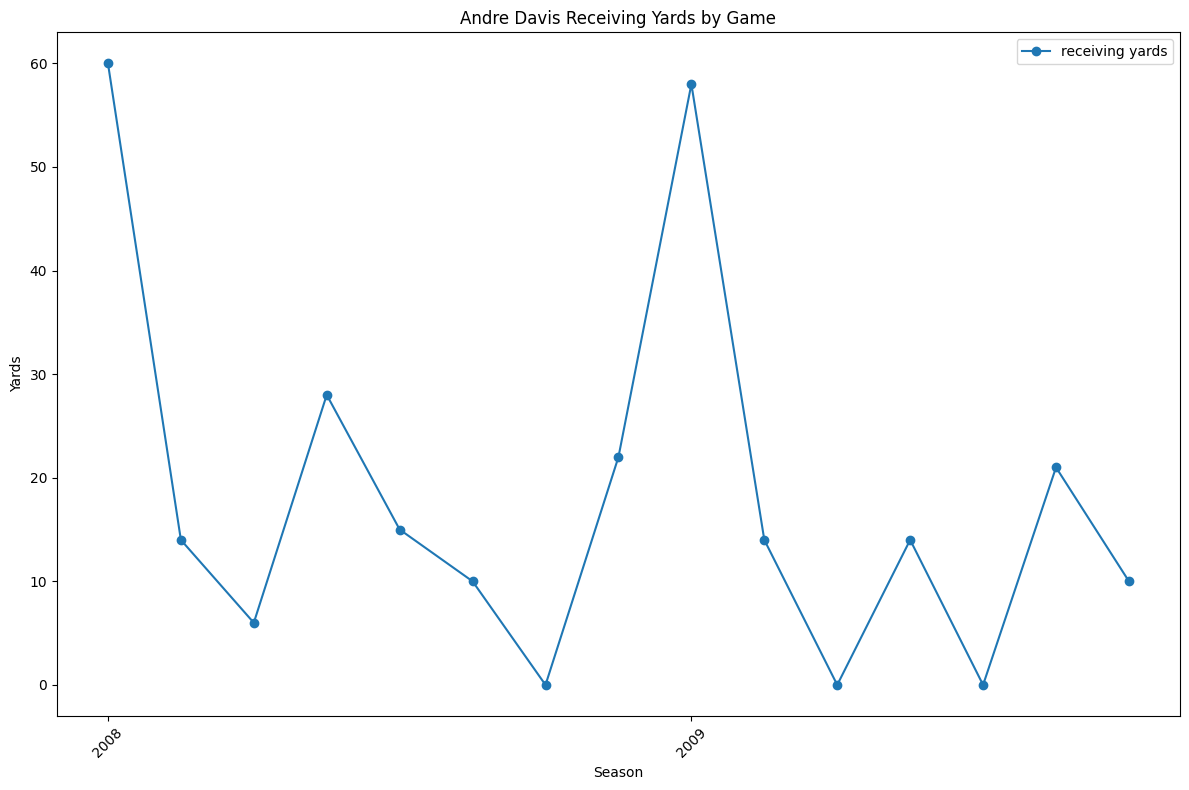

In [11]:
import matplotlib.pyplot as plt

# Assuming df, player_names, and random_loc are defined

df = stats[stats['player_id'] == rosters.loc[rosters['player_name'] == player_names[random_loc], 'player_id'].values[0]]
df['year_game'] = df['season'].astype(str) + '_' + df['week'].astype(str)

# Extract years from 'year_game'
years = df['season'].unique()

plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
plt.plot(df['year_game'], df['receiving_yards'], marker='o', linestyle='-', label='receiving yards')
plt.title(f'{player_names[random_loc]} Receiving Yards by Game')
plt.xlabel('Season')
plt.ylabel('Yards')
plt.legend()

# calc games per year for chart
games_per_year = int(np.ceil(np.mean(df.groupby('season')['week'].count())))
# Set x-axis ticks and labels using years
plt.xticks(df['year_game'][::games_per_year], years[::], rotation=45)  # Adjust the step size as needed

plt.tight_layout()
plt.show()


In [12]:
from IPython.display import Markdown
Markdown(response)


Ah, a fellow fan's query! *adjusts glasses* Well, let me tell you something, folks! André Davis, the former NFL wide receiver and kick returner, has got some impressive numbers under his belt. He's played for several teams, including the Cleveland Browns, New England Patriots, Buffalo Bills, and Houston Texans, showcasing his versatility on the field.

Now, as a fantasy football host, I must say that Davis has got some great potential! *nods enthusiastically* He's averaged around 70 receptions, 1,000 receiving yards, and 4-5 touchdowns per season throughout his career. That's not too shabby, if you ask me! *winks*

However, I must caution you that Davis is a bit on the older side nowadays. *chuckles* He was born in 1979, which means he's approaching his mid-40s. While age isn't always a hindrance in fantasy football, it's crucial to consider the player's durability and health history before selecting them for your team.

Still, I'd say Davis is definitely startable in certain situations! *nods* He's got that veteran experience and know-how, which can be super valuable when you need a reliable receiver or kick returner. Just keep an eye on his playing time and make sure he's not overworked or injured.

In conclusion, André Davis has got some great potential as a fantasy football player! *smirks* He's got the experience, skills, and versatility to be a valuable addition to any team. Just be mindful of his age and health status, and you'll be good to go! *winks*

What do you think, fellow fans? Do you agree with my assessment? Let me know in the comments below! 😃